<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/Duolingo_splittingdata_coldstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will try to answer the following questions in order.

1. Can we train a model to predict whether a student would have forgotten a certain word when they encounter is after some time? 
2. Based on their performance on one word, can we improve our prediction on other words? 
3. Can we extract word-based features that can predict the ease and difficulty of remembering them?
4. Can we predict how easy or difficult a word is to remember for a new language based on our learnings?

Splitting the dataset:

1. first split - keep two languages aside for cold-start testing
2. second split - keep some unseen students aside for testing on seen words. include some low and high trace lengths (10%?)
3. third split - keep some unseen words aside for testing on seen students. include some low and high trace lengths. (20%?)
4. the rest. - student word pairings left.   

In [47]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileid = "1MdLRV3GQ76-xqSGkH1QUDQ1MHrg_JtU_"
filename = "settles.acl16.learning_traces.13m.csv.gz"


downloaded = drive.CreateFile({'id':fileid}) 
downloaded.GetContentFile(filename)

In [48]:
# from https://www.tutorialspoint.com/python-support-for-gzip-files-gzip
import gzip
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
datacsv = []
with gzip.open("settles.acl16.learning_traces.13m.csv.gz", 'rb') as f_in:
  with open("settles.acl16.learning_traces.13m.csv", 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)

In [49]:
datadf = pd.read_csv("settles.acl16.learning_traces.13m.csv")

In [50]:
datadf.shape

(12854226, 12)

Checking for duplicates.

In [51]:
datadf.duplicated().any()

True

Getting number of duplicates

In [52]:
datadf[datadf.duplicated()].shape

(81, 12)

Only 81 duplicated rows. We will delete them nevertheless.

In [53]:
datadf = datadf.drop_duplicates()

In [54]:
datadf.shape

(12854145, 12)

In [55]:
datadf.head(4)

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct
0,1.0,1362076081,27649635,u:FO,de,en,76390c1350a8dac31186187e2fe1e178,lernt/lernen<vblex><pri><p3><sg>,6,4,2,2
1,0.5,1362076081,27649635,u:FO,de,en,7dfd7086f3671685e2cf1c1da72796d7,die/die<det><def><f><sg><nom>,4,4,2,1
2,1.0,1362076081,27649635,u:FO,de,en,35a54c25a2cda8127343f6a82e6f6b7d,mann/mann<n><m><sg><nom>,5,4,1,1
3,0.5,1362076081,27649635,u:FO,de,en,0cf63ffe3dda158bc3dbd55682b355ae,frau/frau<n><f><sg><nom>,6,5,2,1


Which languages are being learnt and by native speakers of which language?

In [ ]:
pd.crosstab(datadf['ui_language'],datadf['learning_language'])

learning_language,de,en,es,fr,it,pt
ui_language,,,,,,
en,1452597,0,3407654,1873716,793919,311480
es,0,3641167,0,0,0,0
it,0,424152,0,0,0,0
pt,0,949460,0,0,0,0


Lexical similarity - similarity of vocabulary, structure of sentences etc. 

English and German have a 60% lexical similarity, while English to Spanish is around 30% similar. On the other hand, the other languages are all fairly similar - French and Italian have 89% lexical similarity, Spanish and Portuguese are 89% similar, French and Portugese are 75% similar. So we need to split one language that is somewhat similar to the others, and one that is somewhat different, to see how learning one language's words can transfer to another when lexical similarities are low and high. 

The following lexical similarity values were taken from Wikipedia.

|    	| en      	| de   	| fr   	| es   	| it 	| pt 	|
|----	|---------	|------	|------	|------	|----	|----	|
| en 	| 1       	|      	|      	|      	|    	|    	|
| de 	| 0.6     	| 1    	|      	|      	|    	|    	|
| fr 	| 0.27    	| 0.29 	| 1    	|      	|    	|    	|
| es 	| ~   0.3 	|      	| 0.75 	| 1    	|    	|    	|
| it 	| ~   0.3 	|      	| 0.89 	| 0.82 	| 1  	|    	|
| pt 	| ~   0.3 	|      	| 0.75 	| 0.89 	|    	| 1  	|


Here is a graph version from [a study](https://community.wolfram.com/groups/-/m/t/2033869)

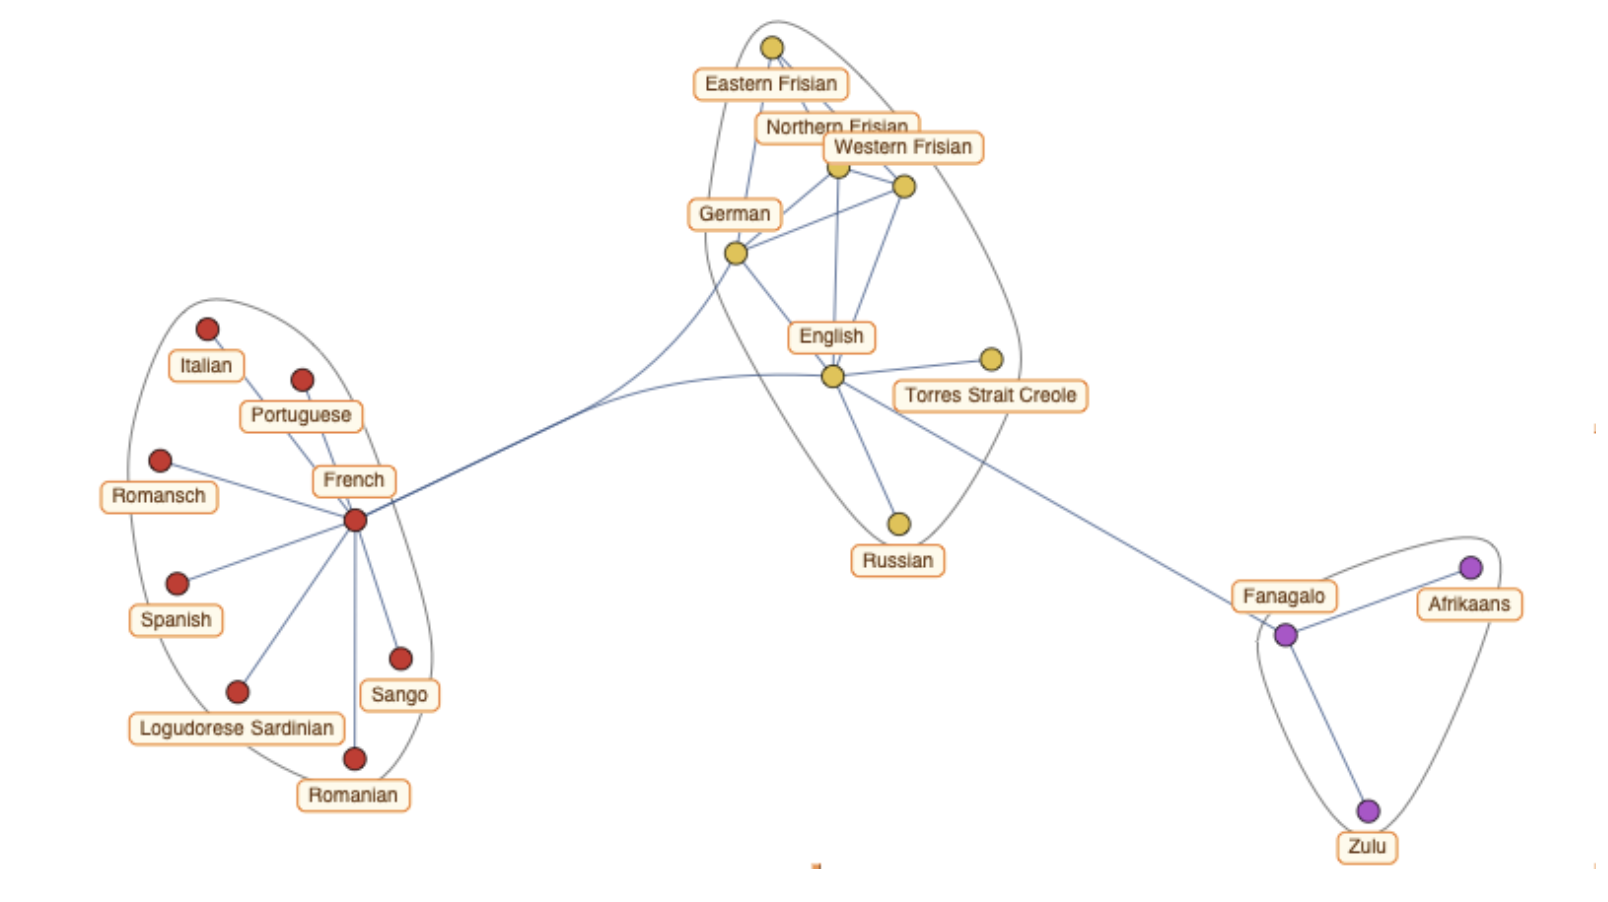

We will separate out two language pairs. 

For an example of a language not sharing too many words with the training set - keeping aside English to German.

Then we can keep aside one that is similar to the native languages - setting aside Italian to English. 

In [56]:
# separating out English to German:
coldstart_entode_df = datadf.loc[(datadf['learning_language']=='de') & (datadf['ui_language']=='en'),:]
coldstart_entode_df.shape

(1452597, 12)

The shape matches the number in the languages cross tab above. We will save this as a separate file.

Saving English (en) to German (de) as a separate test set.

In [ ]:
coldstart_entode_df.to_csv("Coldstart_testset_entode.csv")
from google.colab import files
files.download("Coldstart_testset_entode.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now we can delete it from the current set

In [64]:
datadf = datadf.drop(coldstart_entode_df.index)

Next we separate out Italian to English. 

In [57]:
coldstart_ittoen_df = datadf.loc[(datadf['learning_language']=='en') & (datadf['ui_language']=='it'),:]

In [58]:
coldstart_ittoen_df.shape

(424152, 12)

The shape matches the number in the cross tab above. Now we save this as a separate test file, and delete those rows. 

In [59]:
from google.colab import files
coldstart_ittoen_df.to_csv("Coldstart_testset_ittoen.csv")
files.download("Coldstart_testset_ittoen.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [65]:
datadf = datadf.drop(coldstart_ittoen_df.index)

KeyError: ignored

In [66]:
datadf.shape

(10977396, 12)

In [67]:
datadf.shape[0] + coldstart_ittoen_df.shape[0] + coldstart_entode_df.shape[0]

12854145

The remainder will be the training set for the cold start question. 

In [70]:
import bz2
import pickle
import _pickle as cPickle
from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

Mounted at /content/drive


In [71]:
path_name = '/content/drive/MyDrive/'

In [72]:
compressed_pickle(path_name+"Coldstart_train",datadf)

In [73]:
compressed_pickle(path_name+"Coldstart_en_to_de",coldstart_entode_df)

In [74]:
compressed_pickle(path_name+"Coldstart_it_to_en",coldstart_ittoen_df)

Now we delete the cold start datasets.

In [75]:
del coldstart_ittoen_df, coldstart_entode_df